# VO Performance Benchmarking

In [1]:
from notebook_util import walk, violinplot, categorical_plot

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.3})
import scipy

import sys, os, fnmatch

In [2]:
!ls ./data/

BA_comparison_parking.zip:Zone.Identifier  Harris	   SURF_parkingBA
BRISK					   SURF		   SURF_parkingNoBA
FAST					   SURF_NoRefined  kitti_gt.mat


In [3]:
res_dir = './data/'

In [4]:
!ls ./data/SURF/*.mat
!ls ./data/SURF_parkingBA/*.mat
!ls ./data/SURF_parkingNoBA/*.mat

./data/SURF/dataset@kitti_feat@SURF_time@18_04_46_res.mat
./data/SURF/dataset@kitti_feat@SURF_time@18_10_41_res.mat
./data/SURF/dataset@kitti_feat@SURF_time@18_20_42_res.mat
./data/SURF/dataset@kitti_feat@SURF_time@18_26_46_res.mat
./data/SURF/dataset@kitti_feat@SURF_time@18_28_59_res.mat
./data/SURF_parkingBA/dataset@parking_feat@SURF_trial1.mat
./data/SURF_parkingBA/dataset@parking_feat@SURF_trial2.mat
./data/SURF_parkingBA/dataset@parking_feat@SURF_trial3.mat
./data/SURF_parkingBA/dataset@parking_feat@SURF_trial4.mat
./data/SURF_parkingBA/dataset@parking_feat@SURF_trial5.mat
./data/SURF_parkingNoBA/dataset@parking_feat@SURF_trial1.mat
./data/SURF_parkingNoBA/dataset@parking_feat@SURF_trial2.mat
./data/SURF_parkingNoBA/dataset@parking_feat@SURF_trial3.mat
./data/SURF_parkingNoBA/dataset@parking_feat@SURF_trial4.mat
./data/SURF_parkingNoBA/dataset@parking_feat@SURF_trial5.mat


## Example data

In [5]:
from scipy.io import loadmat
x = loadmat('./data/SURF/dataset@kitti_feat@SURF_time@18_04_46_res.mat')

print(x.keys())

print(x['errs'])
print(type(x['errs']))
print(x['errs'].shape)

fps = x['fps_ct'][0][0]
fps

dict_keys(['__header__', '__version__', '__globals__', 'S', 'bootstrap_frames', 'errs', 'fps_ct', 'frame_ct', 'frame_init', 'ground_truth', 'toc_bootstrap', 'toc_ct', 'toc_param', 'total_time'])
[[3.94744936e-02 1.25798921e+00 5.10657988e-01 1.59032348e+01
  2.43424134e+01 4.80004097e+00]
 [3.89121403e-02 8.82111153e-02 1.72335657e-01 1.05900060e+00
  1.28444254e+00 2.07650133e+01]
 [3.46675200e-01 1.79381070e+00 4.70969015e+00 8.31727564e+00
  2.32331706e+01 3.99343423e+01]]
<class 'numpy.ndarray'>
(3, 6)


3.8964933366262997

In [6]:
from scipy.io import loadmat
y = loadmat('./data/SURF_parkingNoBA/dataset@parking_feat@SURF_trial1.mat')

# print(y.keys())

# print(y['errs'])
# print(type(y['errs']))
# print(y['errs'].shape)

fps = y['frame_ct'][0][0] / y['toc_ct'][0][0]
fps

4.602558917398292

## Loading all data about different features

In [7]:
err_x_, err_y_, err_z_ = [], [], []

for dir_ in os.listdir(res_dir):
    abs_item_path = os.path.join(os.path.abspath(res_dir), dir_)
    if os.path.isdir(abs_item_path):
        if "BA" in abs_item_path:
            continue
        print("Start loading", dir_)
        dir_str = dir_.split('_')
        if 'NoRefined' in dir_str:
            pose_refined = False
        else:
            pose_refined = True
        feature = dir_str[0]
        all_eval_res = fnmatch.filter(os.listdir(abs_item_path), "*.mat")
        # print(all_eval_res)
        for idx, res_mat in enumerate(all_eval_res):
            experiment_name = res_mat.split('.')[0]
            dataset = experiment_name.split('@')[1].split('_')[0]
            mat_path = os.path.join(abs_item_path, res_mat)
            res_array = loadmat(mat_path)
            err_array = res_array['errs']
            # print(err_array)
            err_x = err_array[0,:]
            err_y = err_array[1,:]
            err_z = err_array[2,:]
            eval_dict = {
                'name': experiment_name, 
                'dataset': dataset,
                'fps': res_array['fps_ct'][0][0],
                'feature': feature,
                'pose_refined': pose_refined,
                'dim': 'x',
            }
            dists = ['10m', '40m', '90m', '160m', '250m', '360m']
            eval_x_dict = copy.deepcopy(eval_dict)
            for ii, dist in enumerate(dists):
                eval_x_dict.update({dist: err_x[ii]})
            eval_y_dict = copy.deepcopy(eval_dict)
            for ii, dist in enumerate(dists):
                eval_y_dict.update({dist: err_y[ii]})
            eval_z_dict = copy.deepcopy(eval_dict)
            for ii, dist in enumerate(dists):
                eval_z_dict.update({dist: err_z[ii]})
                
            err_x_df = pd.DataFrame([eval_x_dict])
            err_y_df = pd.DataFrame([eval_y_dict])
            err_z_df = pd.DataFrame([eval_z_dict])
            
            err_x_.append(err_x_df)
            err_y_.append(err_y_df)
            err_z_.append(err_z_df)
            
all_err_x_df = pd.concat(err_x_, ignore_index=True)
all_err_y_df = pd.concat(err_y_, ignore_index=True)
all_err_z_df = pd.concat(err_z_, ignore_index=True)

Start loading SURF
Start loading BRISK
Start loading FAST
Start loading Harris
Start loading SURF_NoRefined


In [8]:
all_err_x_df

,name,dataset,fps,feature,pose_refined,dim,10m,40m,90m,160m,250m,360m
0,dataset@kitti_feat@SURF_time@18_04_46_res,kitti,3.896493,SURF,True,x,0.039474,1.257989,0.510658,15.903235,24.342413,4.800041
1,dataset@kitti_feat@SURF_time@18_28_59_res,kitti,4.287627,SURF,True,x,0.323520,2.237832,0.751671,1.734819,14.915926,7.429808
2,dataset@kitti_feat@SURF_time@18_26_46_res,kitti,4.312658,SURF,True,x,0.085869,0.942292,2.360463,21.553452,2.000580,29.715358
3,dataset@kitti_feat@SURF_time@18_20_42_res,kitti,4.197096,SURF,True,x,0.055379,0.913255,1.673112,6.848231,30.658558,11.480315
4,dataset@kitti_feat@SURF_time@18_10_41_res,kitti,3.780812,SURF,True,x,0.038092,1.116161,4.515377,9.782360,7.403206,0.792963
5,dataset@kitti_feat@BRISK_time@19_14_37_res,kitti,3.328288,BRISK,True,x,0.009180,0.088940,2.861423,8.438244,37.344510,18.988713
6,dataset@kitti_feat@BRISK_time@19_24_08_res,kitti,3.339350,BRISK,True,x,0.155406,0.398512,1.601859,3.084105,10.748082,9.618774
7,dataset@kitti_feat@BRISK_time@19_20_00_res,kitti,3.361014,BRISK,True,x,0.131986,0.560008,0.593688,13.294722,27.163373,22.088488
8,dataset@kitti_feat@BRISK_time@19_11_53_res,kitti,3.384857,BRISK,True,x,0.012093,0.164297,0.035429,14.769481,39.956757,11.952734
9,dataset@kitti_feat@BRISK_time@19_17_19_res,kitti,3.351032,BRISK,True,x,0.035630,0.286860,0.010466,15.843466,15.048516,0.943167


In [9]:
#all_err_y_df

In [10]:
#all_err_z_df

### Mean-Statistics

In [11]:
chosen_feats = ['SURF', 'Harris', 'BRISK', 'FAST']
    
all_err_x_df_refinied = all_err_x_df[all_err_x_df.pose_refined == True]
all_err_y_df_refinied = all_err_y_df[all_err_y_df.pose_refined == True]
all_err_z_df_refinied = all_err_z_df[all_err_z_df.pose_refined == True]

for feat in chosen_feats:
    print(feat, ":", len(all_err_z_df_refinied[all_err_z_df_refinied.feature == feat]))

z_stat = []
x_stat = []
for feat in chosen_feats:
    all_err_z_df_ = all_err_z_df_refinied[all_err_z_df_refinied.feature == feat]
    all_err_x_df_ = all_err_x_df_refinied[all_err_x_df_refinied.feature == feat]
    
    z_stat_df = all_err_z_df_.drop(['pose_refined'], axis=1).agg(['mean', 'std'])
    x_stat_df = all_err_x_df_.drop(['pose_refined'], axis=1).agg(['mean', 'std'])
    
    # stat_df = all_err_z_df_.agg(['mean', 'std'])
    x_stat_df.index = feat+'_'+x_stat_df.index.values
    z_stat_df.index = feat+'_'+z_stat_df.index.values
    x_stat.append(x_stat_df)
    z_stat.append(z_stat_df)
    
x_stat_df_all = pd.concat(x_stat) # , ignore_index=True
z_stat_df_all = pd.concat(z_stat) # , ignore_index=True
# z_stat_df_all.index.name = 'Metrics'

SURF : 5
Harris : 5
BRISK : 5
FAST : 6


In [12]:
x_stat_df_all

,fps,10m,40m,90m,160m,250m,360m
SURF_mean,4.094937,0.108467,1.293506,1.962256,11.164419,15.864137,10.843697
SURF_std,0.241362,0.121747,0.545987,1.607269,7.743470,11.783895,11.244360
Harris_mean,3.817270,0.135506,1.567472,2.857834,9.383223,20.492467,17.834197
Harris_std,0.033657,0.137735,0.860389,3.878832,4.788642,11.591706,6.162775
BRISK_mean,3.352908,0.068859,0.299723,1.020573,11.086004,26.052248,12.718375
BRISK_std,0.021679,0.069576,0.187379,1.214463,5.294358,13.013308,8.306103
FAST_mean,4.246576,0.053769,0.524174,1.149677,14.749192,26.314088,17.164881
FAST_std,0.109770,0.045484,0.317153,0.743842,6.616331,19.870899,16.835768


In [13]:
all_err_x_df_no_refinied = all_err_x_df[all_err_x_df.pose_refined == False]
print(np.mean(all_err_x_df_no_refinied.fps.values))
print(np.std(all_err_x_df_no_refinied.fps.values))

4.110989657884739
0.24680753589875962


### Result visualization

In [14]:
err_x_, err_y_, err_z_ = [], [], []

for dir_ in os.listdir(res_dir):
    abs_item_path = os.path.join(os.path.abspath(res_dir), dir_)
    if os.path.isdir(abs_item_path):
        if "BA" in abs_item_path:
            continue
        print("Start loading", dir_)
        dir_str = dir_.split('_')
        if 'NoRefined' in dir_str:
            pose_refined = False
        else:
            pose_refined = True
        feature = dir_str[0]
        all_eval_res = fnmatch.filter(os.listdir(abs_item_path), "*.mat")
        # print(all_eval_res)
        for idx, res_mat in enumerate(all_eval_res):
            experiment_name = res_mat.split('.')[0]
            dataset = experiment_name.split('@')[1].split('_')[0]
            mat_path = os.path.join(abs_item_path, res_mat)
            res_array = loadmat(mat_path)
            err_array = res_array['errs']
            # print(err_array)
            err_x = err_array[0,:]
            err_y = err_array[1,:]
            err_z = err_array[2,:]
            eval_dict = {
                'name': experiment_name, 
                'dataset': dataset,
                'feature': feature,
                'pose_refined': pose_refined,
                'dim': 'x',
            }
            dists = ['10m', '40m', '90m', '160m', '250m', '360m']
            dists_number = [10, 40, 90, 160, 250, 360]
            x_sub, y_sub, z_sub = [], [], []
            for ii, dist in enumerate(dists_number):
                eval_x_dict = copy.deepcopy(eval_dict)
                eval_x_dict.update({'dist': dist})
                eval_x_dict.update({'error': err_x[ii]})
                x_sub.append(eval_x_dict)
                            
                eval_y_dict = copy.deepcopy(eval_dict)
                eval_y_dict.update({'dist': dist})
                eval_y_dict.update({'error': err_y[ii]})
                y_sub.append(eval_y_dict)
                            
                eval_z_dict = copy.deepcopy(eval_dict)
                eval_z_dict.update({'dist': dist})
                eval_z_dict.update({'error': err_z[ii]})
                z_sub.append(eval_z_dict)
#             eval_x_dict = copy.deepcopy(eval_dict)
#             for ii, dist in enumerate(dists):
#                 eval_x_dict.update({dist: err_x[ii]})
#             eval_y_dict = copy.deepcopy(eval_dict)
#             for ii, dist in enumerate(dists):
#                 eval_y_dict.update({dist: err_y[ii]})
#             eval_z_dict = copy.deepcopy(eval_dict)
#             for ii, dist in enumerate(dists):
#                 eval_z_dict.update({dist: err_z[ii]})
                
#             err_x_df = pd.DataFrame([eval_x_dict])
#             err_y_df = pd.DataFrame([eval_y_dict])
#             err_z_df = pd.DataFrame([eval_z_dict])
                            
            err_x_df = pd.DataFrame(x_sub)
            err_y_df = pd.DataFrame(y_sub)
            err_z_df = pd.DataFrame(z_sub)
            
            err_x_.append(err_x_df)
            err_y_.append(err_y_df)
            err_z_.append(err_z_df)
            
all_err_x_df_by_dist = pd.concat(err_x_, ignore_index=True)
all_err_y_df_by_dist = pd.concat(err_y_, ignore_index=True)
all_err_z_df_by_dist = pd.concat(err_z_, ignore_index=True)

Start loading SURF
Start loading BRISK
Start loading FAST
Start loading Harris
Start loading SURF_NoRefined


In [15]:
all_err_x_df_by_dist
# all_err_y_df_by_dist

,name,dataset,feature,pose_refined,dim,dist,error
0,dataset@kitti_feat@SURF_time@18_04_46_res,kitti,SURF,True,x,10,0.039474
1,dataset@kitti_feat@SURF_time@18_04_46_res,kitti,SURF,True,x,40,1.257989
2,dataset@kitti_feat@SURF_time@18_04_46_res,kitti,SURF,True,x,90,0.510658
3,dataset@kitti_feat@SURF_time@18_04_46_res,kitti,SURF,True,x,160,15.903235
4,dataset@kitti_feat@SURF_time@18_04_46_res,kitti,SURF,True,x,250,24.342413
...,...,...,...,...,...,...,...
151,dataset@kitti_feat@SURF_time@18_35_00_NoRefine...,kitti,SURF,False,x,40,1.670407
152,dataset@kitti_feat@SURF_time@18_35_00_NoRefine...,kitti,SURF,False,x,90,1.097711
153,dataset@kitti_feat@SURF_time@18_35_00_NoRefine...,kitti,SURF,False,x,160,0.621929
154,dataset@kitti_feat@SURF_time@18_35_00_NoRefine...,kitti,SURF,False,x,250,3.379097


/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-

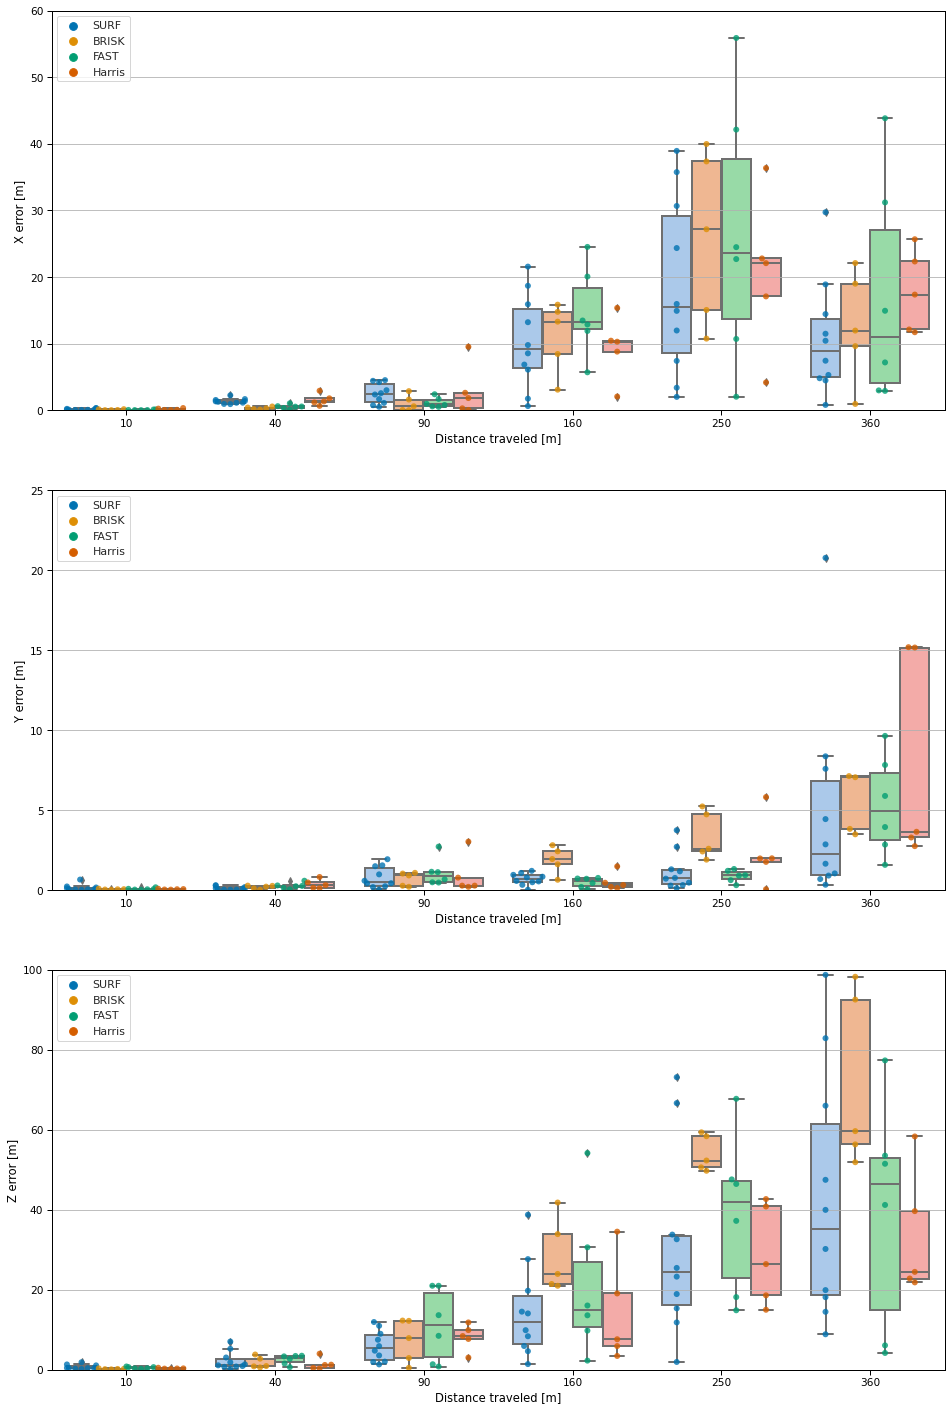

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(16, 25))

categorical_plot(
    axes=axes[0],
    df=all_err_x_df_by_dist,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='X error [m]',
    ylim=[0.0, 60],
    kind='box',
    lgd_labels=['SURF', 'BRISK', 'FAST', 'Harris'],
    group='feature',
    loc='upper left',
)

categorical_plot(
    axes=axes[1],
    df=all_err_y_df_by_dist,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Y error [m]',
    ylim=[0.0, 25],
    kind='box',
    lgd_labels=['SURF', 'BRISK', 'FAST', 'Harris'],
    group='feature',
    loc='upper left',
)

categorical_plot(
    axes=axes[2],
    df=all_err_z_df_by_dist,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Z error [m]',
    ylim=[0.0, 100],
    kind='box',
    lgd_labels=['SURF', 'BRISK', 'FAST', 'Harris'],
    group='feature',
    loc='upper left',
)

plt.savefig("./feat_comp.pdf", dpi=300)

plt.show()

In [17]:
plt.close()

In [18]:
fig0, axes0 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes0,
    df=all_err_x_df_by_dist,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='X error [m]',
    ylim=[0.0, 60],
    kind='box',
    lgd_labels=['SURF', 'BRISK', 'FAST', 'Harris'],
    group='feature',
    loc='upper left',
)

plt.savefig("./feat_comp_x.pdf", dpi=300)

plt.close()

fig1, axes1 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes1,
    df=all_err_y_df_by_dist,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Y error [m]',
    ylim=[0.0, 25],
    kind='box',
    lgd_labels=['SURF', 'BRISK', 'FAST', 'Harris'],
    group='feature',
    loc='upper left',
)

plt.savefig("./feat_comp_y.pdf", dpi=300)

plt.close()

fig2, axes2 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes2,
    df=all_err_z_df_by_dist,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Z error [m]',
    ylim=[0.0, 100],
    kind='box',
    lgd_labels=['SURF', 'BRISK', 'FAST', 'Harris'],
    group='feature',
    loc='upper left',
)

plt.savefig("./feat_comp_z.pdf", dpi=300)

plt.close()

/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/he/miniconda/envs/py38/lib/python3.8/site-

## Performance comparison or without pose refinement

In [19]:
all_err_x_df_by_dist_refine = all_err_x_df_by_dist[all_err_x_df_by_dist.feature == 'SURF']
all_err_y_df_by_dist_refine = all_err_y_df_by_dist[all_err_y_df_by_dist.feature == 'SURF']
all_err_z_df_by_dist_refine = all_err_z_df_by_dist[all_err_z_df_by_dist.feature == 'SURF']

In [20]:
# all_err_x_df_by_dist_refine

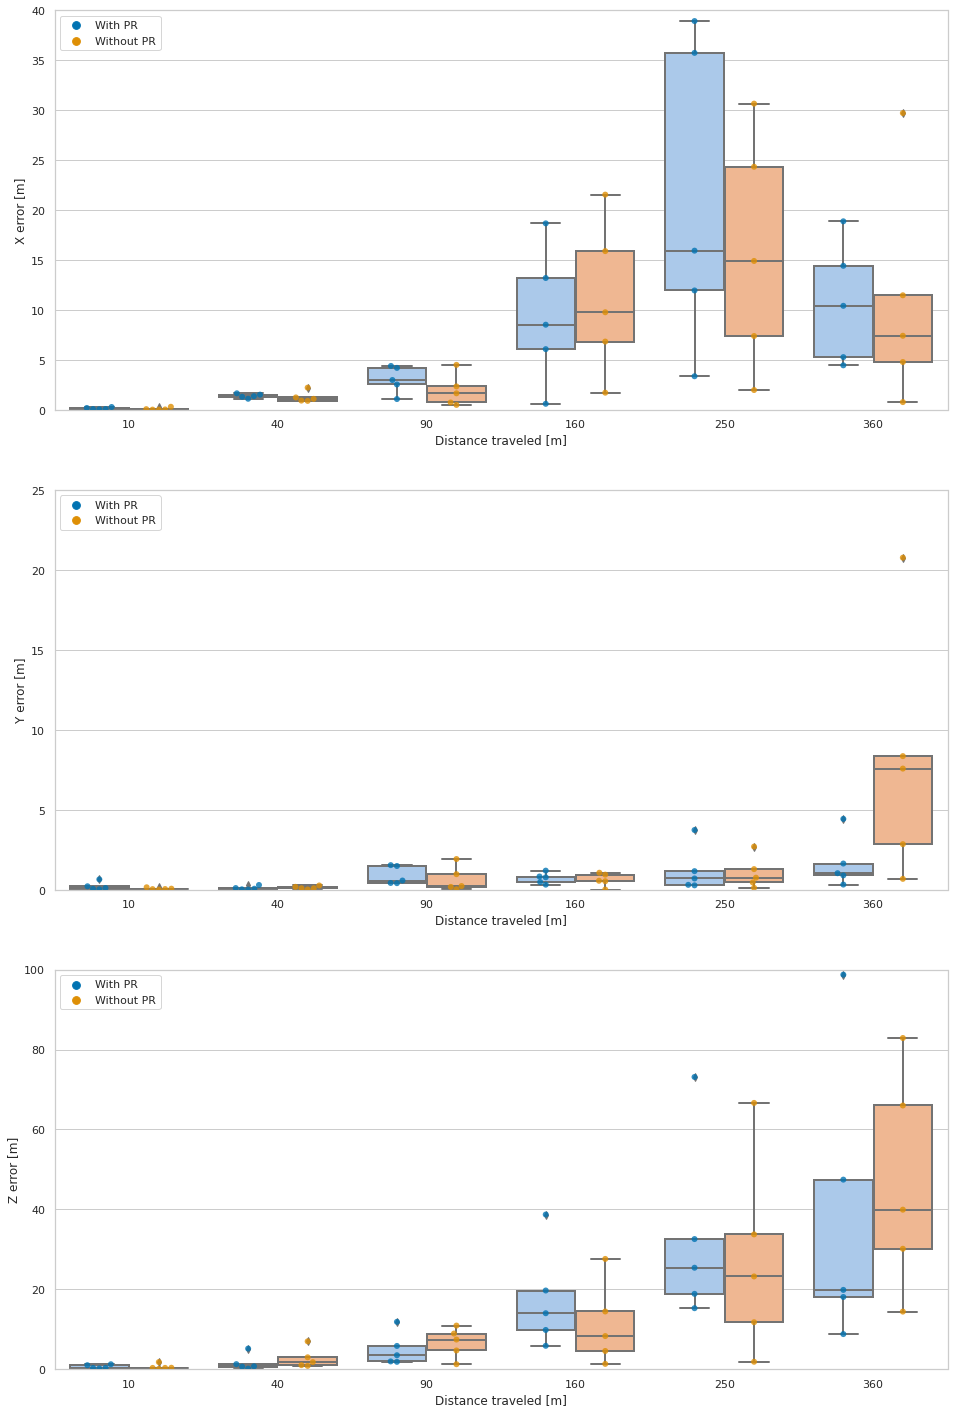

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(16, 25))

categorical_plot(
    axes=axes[0],
    df=all_err_x_df_by_dist_refine,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='X error [m]',
    ylim=[0.0, 40],
    kind='box',
    lgd_labels=['With PR', 'Without PR'],
    group='pose_refined',
    loc='upper left',
)

categorical_plot(
    axes=axes[1],
    df=all_err_y_df_by_dist_refine,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Y error [m]',
    ylim=[0.0, 25],
    kind='box',
    lgd_labels=['With PR', 'Without PR'],
    group='pose_refined',
    loc='upper left',
)

categorical_plot(
    axes=axes[2],
    df=all_err_z_df_by_dist_refine,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Z error [m]',
    ylim=[0.0, 100],
    kind='box',
    lgd_labels=['With PR', 'Without PR'],
    group='pose_refined',
    loc='upper left',
)

plt.show()

plt.savefig("./refine_comp.pdf", dpi=300)

In [22]:
plt.close()

In [23]:
fig0, axes0 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes0,
    df=all_err_x_df_by_dist_refine,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='X error [m]',
    ylim=[0.0, 40],
    kind='box',
    lgd_labels=['With PR', 'W/O PR'],
    group='pose_refined',
    loc='upper left',
)

plt.savefig("./refine_comp_x.pdf", dpi=300)

plt.close()

fig1, axes1 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes1,
    df=all_err_y_df_by_dist_refine,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Y error [m]',
    ylim=[0.0, 25],
    kind='box',
    lgd_labels=['With PR', 'W/O PR'],
    group='pose_refined',
    loc='upper left',
)

plt.savefig("./refine_comp_y.pdf", dpi=300)

plt.close()

fig2, axes2 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes2,
    df=all_err_z_df_by_dist_refine,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Z error [m]',
    ylim=[0.0, 100],
    kind='box',
    lgd_labels=['With PR', 'W/O PR'],
    group='pose_refined',
    loc='upper left',
)

plt.savefig("./refine_comp_z.pdf", dpi=300)

plt.close()

## Performance comparison or without Bundle Adjustment

In [24]:
err_x_ba, err_y_ba, err_z_ba = [], [], []

for dir_ in os.listdir(res_dir):
    abs_item_path = os.path.join(os.path.abspath(res_dir), dir_)
    if os.path.isdir(abs_item_path):
        if not ("BA" in abs_item_path):
            continue
        print("Start loading", dir_)
        dir_str = dir_.split('_')
        if 'NoRefined' in dir_str:
            pose_refined = False
        else:
            pose_refined = True
        if 'NoBA' in abs_item_path:
            use_ba = False
        else:
            use_ba = True
        feature = dir_str[0]
        all_eval_res = fnmatch.filter(os.listdir(abs_item_path), "*.mat")
        # print(all_eval_res)
        for idx, res_mat in enumerate(all_eval_res):
            experiment_name = res_mat.split('.')[0]
            dataset = experiment_name.split('@')[1].split('_')[0]
            mat_path = os.path.join(abs_item_path, res_mat)
            res_array = loadmat(mat_path)
            err_array = res_array['errs']
            # print(err_array)
            err_x = err_array[0,:]
            err_y = err_array[1,:]
            err_z = err_array[2,:]
            eval_dict = {
                'name': experiment_name, 
                'dataset': dataset,
                'fps': res_array['frame_ct'][0][0] / res_array['toc_ct'][0][0],
                'feature': feature,
                'use_ba': use_ba,
                'dim': 'x',
            }
            dists = ['2m', '8m', '18m', '32m', '50m', '72m']
            eval_x_dict = copy.deepcopy(eval_dict)
            for ii, dist in enumerate(dists):
                eval_x_dict.update({dist: err_x[ii]})
            eval_y_dict = copy.deepcopy(eval_dict)
            for ii, dist in enumerate(dists):
                eval_y_dict.update({dist: err_y[ii]})
            eval_z_dict = copy.deepcopy(eval_dict)
            for ii, dist in enumerate(dists):
                eval_z_dict.update({dist: err_z[ii]})
                
            err_x_df = pd.DataFrame([eval_x_dict])
            err_y_df = pd.DataFrame([eval_y_dict])
            err_z_df = pd.DataFrame([eval_z_dict])
            
            err_x_ba.append(err_x_df)
            err_y_ba.append(err_y_df)
            err_z_ba.append(err_z_df)
            
all_err_x_ba_df = pd.concat(err_x_ba, ignore_index=True)
all_err_y_ba_df = pd.concat(err_y_ba, ignore_index=True)
all_err_z_ba_df = pd.concat(err_z_ba, ignore_index=True)

Start loading SURF_parkingBA
Start loading SURF_parkingNoBA


In [25]:
all_err_x_ba_df

,name,dataset,fps,feature,use_ba,dim,2m,8m,18m,32m,50m,72m
0,dataset@parking_feat@SURF_trial5,parking,1.825821,SURF,True,x,0.077300,0.057946,0.169989,0.174397,0.738321,0.363052
1,dataset@parking_feat@SURF_trial3,parking,1.764237,SURF,True,x,0.019720,0.008994,0.117789,0.126775,0.435642,0.776631
2,dataset@parking_feat@SURF_trial2,parking,1.519207,SURF,True,x,0.031746,0.246202,0.530691,0.686962,0.243746,0.326374
3,dataset@parking_feat@SURF_trial4,parking,1.617154,SURF,True,x,0.066429,0.023389,0.507723,0.391924,0.108496,0.728991
4,dataset@parking_feat@SURF_trial1,parking,1.679921,SURF,True,x,0.006739,0.111445,0.199541,0.034695,0.427326,0.637729
5,dataset@parking_feat@SURF_trial5,parking,4.550254,SURF,False,x,0.006551,0.094443,0.938013,0.535039,0.431276,1.560447
6,dataset@parking_feat@SURF_trial3,parking,4.491860,SURF,False,x,0.010546,0.432339,0.674575,0.848031,0.176252,3.696459
7,dataset@parking_feat@SURF_trial2,parking,4.603344,SURF,False,x,0.010265,0.013701,0.214639,0.430471,0.441319,1.072316
8,dataset@parking_feat@SURF_trial4,parking,4.544613,SURF,False,x,0.017387,0.289743,0.494881,1.392555,2.466073,2.877280
9,dataset@parking_feat@SURF_trial1,parking,4.602559,SURF,False,x,0.007404,0.193011,1.059583,1.078947,0.154806,2.708249


In [26]:
wba = all_err_x_ba_df[all_err_x_ba_df.use_ba==True]
woba = all_err_x_ba_df[all_err_x_ba_df.use_ba==False]

print(np.mean(wba.fps.values), np.std(wba.fps.values))
print(np.mean(woba.fps.values), np.std(woba.fps.values))

1.6812679904120689 0.10784739666917714
4.558526154778248 0.04160270167380616


In [27]:
err_x_ba, err_y_ba, err_z_ba = [], [], []

for dir_ in os.listdir(res_dir):
    abs_item_path = os.path.join(os.path.abspath(res_dir), dir_)
    if os.path.isdir(abs_item_path):
        if not ("BA" in abs_item_path):
            continue
        print("Start loading", dir_)
        dir_str = dir_.split('_')
        if 'NoRefined' in dir_str:
            pose_refined = False
        else:
            pose_refined = True
        if 'NoBA' in abs_item_path:
            use_ba = False
        else:
            use_ba = True
        feature = dir_str[0]
        all_eval_res = fnmatch.filter(os.listdir(abs_item_path), "*.mat")
        # print(all_eval_res)
        for idx, res_mat in enumerate(all_eval_res):
            experiment_name = res_mat.split('.')[0]
            dataset = experiment_name.split('@')[1].split('_')[0]
            mat_path = os.path.join(abs_item_path, res_mat)
            res_array = loadmat(mat_path)
            err_array = res_array['errs']
            # print(err_array)
            err_x = err_array[0,:]
            err_y = err_array[1,:]
            err_z = err_array[2,:]
            eval_dict = {
                'name': experiment_name, 
                'dataset': dataset,
                'feature': feature,
                'use_ba': use_ba,
                'dim': 'x',
            }
            dists_number = [2, 8, 18, 32, 50, 72]
            x_sub, y_sub, z_sub = [], [], []
            for ii, dist in enumerate(dists_number):
                eval_x_dict = copy.deepcopy(eval_dict)
                eval_x_dict.update({'dist': dist})
                eval_x_dict.update({'error': err_x[ii]})
                x_sub.append(eval_x_dict)
                            
                eval_y_dict = copy.deepcopy(eval_dict)
                eval_y_dict.update({'dist': dist})
                eval_y_dict.update({'error': err_y[ii]})
                y_sub.append(eval_y_dict)
                            
                eval_z_dict = copy.deepcopy(eval_dict)
                eval_z_dict.update({'dist': dist})
                eval_z_dict.update({'error': err_z[ii]})
                z_sub.append(eval_z_dict)
                
            err_x_df = pd.DataFrame(x_sub)
            err_y_df = pd.DataFrame(y_sub)
            err_z_df = pd.DataFrame(z_sub)

            err_x_ba.append(err_x_df)
            err_y_ba.append(err_y_df)
            err_z_ba.append(err_z_df)
            
all_err_x_ba_df = pd.concat(err_x_ba, ignore_index=True)
all_err_y_ba_df = pd.concat(err_y_ba, ignore_index=True)
all_err_z_ba_df = pd.concat(err_z_ba, ignore_index=True)

Start loading SURF_parkingBA
Start loading SURF_parkingNoBA


In [28]:
all_err_x_ba_df

,name,dataset,feature,use_ba,dim,dist,error
0,dataset@parking_feat@SURF_trial5,parking,SURF,True,x,2,0.077300
1,dataset@parking_feat@SURF_trial5,parking,SURF,True,x,8,0.057946
2,dataset@parking_feat@SURF_trial5,parking,SURF,True,x,18,0.169989
3,dataset@parking_feat@SURF_trial5,parking,SURF,True,x,32,0.174397
4,dataset@parking_feat@SURF_trial5,parking,SURF,True,x,50,0.738321
5,dataset@parking_feat@SURF_trial5,parking,SURF,True,x,72,0.363052
6,dataset@parking_feat@SURF_trial3,parking,SURF,True,x,2,0.019720
7,dataset@parking_feat@SURF_trial3,parking,SURF,True,x,8,0.008994
8,dataset@parking_feat@SURF_trial3,parking,SURF,True,x,18,0.117789
9,dataset@parking_feat@SURF_trial3,parking,SURF,True,x,32,0.126775


In [29]:
fig0, axes0 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes0,
    df=all_err_x_ba_df,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='X error [m]',
    ylim=[0.0, 4],
    kind='box',
    lgd_labels=['W/O BA', 'With BA'],
    group='use_ba',
    loc='upper left',
)

plt.savefig("./ba_comp_x.pdf", dpi=300)

plt.close()

fig1, axes1 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes1,
    df=all_err_y_ba_df,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Y error [m]',
    ylim=[0.0, 0.5],
    kind='box',
    lgd_labels=['W/O BA', 'With BA'],
    group='use_ba',
    loc='upper left',
)

plt.savefig("./ba_comp_y.pdf", dpi=300)

plt.close()

fig2, axes2 = plt.subplots(figsize=(16, 8))

categorical_plot(
    axes=axes2,
    df=all_err_z_ba_df,
    metric='error',
    catogory='dist',
    title='',
    xlabel='Distance traveled [m]',
    ylabel='Z error [m]',
    ylim=[0.0, 1.5],
    kind='box',
    lgd_labels=['W/O BA', 'With BA'],
    group='use_ba',
    loc='upper left',
)

plt.savefig("./ba_comp_z.pdf", dpi=300)

plt.close()